In [1]:
import numpy as np

from src.parsers import HMParser
from src.resources import BaseResource, Generator
from src.utils.preprocessing import to_probabilistic

from matplotlib import pyplot as plt

In [2]:
# Load the Excel file

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
print(data.__doc__)


    Inherits from BaseParser.
    Excel reader for the energy community scenario.
    Has as arguments:
    - file_path: str
    - ec_id: int
    - vals: int -> Not used in current version

    When initialized will have the following information:
    - Generators (.generator)
    - Loads (.load)
    - Storage (.storage)
    - Charging stations (.charging_station)
    - Peers (.peers)
    - Vehicles (.vehicle)
    


In [4]:
data.generator

{'p_forecast': array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.5061133875, 1.4411243165, 3.394061953,
         5.741970125, 7.572848065, 8.76071385, 9.415491925, 9.374454205,
         8.620903585, 7.44523669, 5.628980655, 3.1658828705, 1.3267300085,
         0.467651776, 0.0, 0.0, 0.0, 0.0, 0.0],
        [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0,
         30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0,
         30.0, 30.0],
        [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
         10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
         10.0, 10.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.2530566935, 0.7205621585,
         1.6970309765, 2.870985063, 3.7864240325, 4.380356924,
         4.707745963, 4.687227102, 4.310451792, 3.722618346, 2.8144903285,
         1.5829414355, 0.6633650045, 0.233825888, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.126528347, 0.360281079, 0.848515488,
         1.4354925315,

In [5]:
# Define the base import and export values

imports = BaseResource(name='imports',
                       value=np.zeros((1, data.peers['import_contracted_p_max'].shape[1])),
                       lower_bound=np.zeros((1, data.peers['import_contracted_p_max'].shape[1])),
                       upper_bound=np.max(data.peers['import_contracted_p_max'], axis=0),
                       cost=np.max(data.peers['buy_price'], axis=0))

exports = BaseResource(name='exports',
                       value=np.zeros((1, data.peers['export_contracted_p_max'].shape[1])),
                       lower_bound=np.zeros((1, data.peers['export_contracted_p_max'].shape[1])),
                       upper_bound=np.max(data.peers['export_contracted_p_max'], axis=0),
                       cost=np.max(data.peers['sell_price'], axis=0))

In [6]:
# Define generators

gens = Generator(name='gens',
                 value=np.zeros(data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(data.generator['p_forecast'].shape),
                 upper_bound=data.generator['p_forecast'],
                 cost=data.generator['cost_parameter_b'],
                 cost_nde=data.generator['cost_nde'],
                 is_renewable=data.generator['type_generator'])

In [7]:
to_probabilistic(gens.upper_bound[0], lcb=0.1, ucb=0.9)

array([ 6.49575781,  0.42612525,  3.93931471,  2.2480104 ,  0.        ,
        1.55880901, 11.56160752,  0.39071613,  5.36419192,  4.79535428,
        1.20620482,  2.01722223,  3.69156538,  3.60818298,  4.44081825,
        2.19019419,  0.9936163 ,  3.23595082,  5.56107033,  3.40209668,
        0.23457734,  6.8628407 ,  0.57550982,  0.        ])

In [8]:
gens.upper_bound[0]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.5061133875, 1.4411243165, 3.394061953,
       5.741970125, 7.572848065, 8.76071385, 9.415491925, 9.374454205,
       8.620903585, 7.44523669, 5.628980655, 3.1658828705, 1.3267300085,
       0.467651776, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [18]:
# Create a probabilistic version of the generators

ucb = 0.9
lcb = 0.1

# create the upper and lower bounds based on the confidence bounds and apply to the generators

temp_lower_bound, temp_upper_bound = to_probabilistic(gens.upper_bound[0].astype(float), lcb=lcb, ucb=ucb, method='random')

In [19]:
temp_upper_bound

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.86783943,  2.26387766,  4.29724601,  7.22418806, 13.59502107,
       14.52668607, 12.40201544, 15.29071515,  9.56092936, 12.29007078,
        9.41947226,  4.27420772,  1.55320298,  0.59390223,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

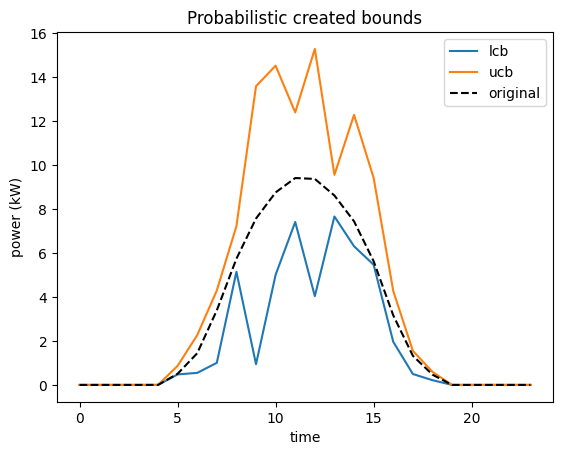

In [22]:
fig = plt.figure()

# plot
plt.plot(temp_lower_bound)
plt.plot(temp_upper_bound)
plt.plot(gens.upper_bound[0], 'k--')

# add legends
plt.legend(['lcb', 'ucb', 'original'])

# add labels
plt.xlabel('time')
plt.ylabel('power (kW)')

# add title
plt.title('Probabilistic created bounds')

# show plot
plt.show()